In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

from conditionalconformal.synthetic_data import generate_cqr_data, indicator_matrix
from conditionalconformal import CondConf

In [3]:
# generate data
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(seed=1)

# fit a fourth order polynomial
poly = PolynomialFeatures(4)
reg = LinearRegression().fit(poly.fit_transform(x_train_final), y_train_final)

# nominal level is 0.9
alpha = 0.1

# score function is residual
score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))
score_inv_fn_ub = lambda s, x : [-np.inf, reg.predict(poly.fit_transform(x)) + s]
score_inv_fn_lb = lambda s, x : [reg.predict(poly.fit_transform(x)) + s, np.inf]

# coverage on indicators of all sub-intervals with endpoints in [0,0.5,1,..,5]
eps = 0.5
disc = np.arange(0, 5 + eps, eps)

def phi_fn_groups(x):
    return indicator_matrix(x, disc)

# coverage on Gaussians with mu=loc and sd=scale 
# scale = 1 for x != [1.5, 3.5]
eval_locs = [1.5, 3.5]
eval_scale = 0.2

other_locs = [0.5, 2.5, 4.5]
other_scale = 1

def phi_fn_shifts(x):
    shifts = [norm.pdf(x, loc=loc, scale=eval_scale).reshape(-1,1)
                   for loc in eval_locs]
    shifts.extend([norm.pdf(x, loc=loc, scale=other_scale).reshape(-1,1)
                   for loc in other_locs])
    shifts.append(np.ones((x.shape[0], 1)))
    return np.concatenate(shifts, axis=1)

# intercept only phi_fn
def phi_fn_intercept(x):
    return np.ones((x.shape[0], 1))

In [4]:
experiment = 'groups' # valid choices: ['groups', 'shifts', 'agnostic']

In [5]:
if experiment == 'groups':
    phi_fn = phi_fn_groups
    infinite_params = {}
elif experiment == 'shifts':
    phi_fn = phi_fn_shifts
    infinite_params = {}
elif experiment == 'agnostic':
    phi_fn = phi_fn_intercept
    infinite_params = {'kernel': 'rbf', 'gamma': 12.5, 'lambda': 0.005}
else:
    raise ValueError(f"Invalid value for experiment: {experiment}.")

cond_conf = CondConf(score_fn, phi_fn, infinite_params)
cond_conf.setup_problem(x_calib, y_calib)

n_test = len(x_test)

lbs = np.zeros((n_test,))
ubs = np.zeros((n_test,))

i = 0
for x_t in tqdm(x_test):
    res = cond_conf.predict(alpha / 2, x_t, score_inv_fn_lb)
    lbs[i] = res[0]
    res = cond_conf.predict(1 - alpha / 2, x_t, score_inv_fn_ub)
    ubs[i] = res[1]
    i += 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 15.07it/s]


In [32]:
quantile = 0.95

import mosek.fusion as F
from scipy.optimize import linprog
import osqp
import scipy.sparse

def benchmark_mosek(val):
    S = np.concatenate([cond_conf.scores_calib, [val]], dtype=float)
    Phi = np.concatenate([cond_conf.phi_calib, cond_conf.Phi_fn(x_test[2].reshape(-1,1))], axis=0, dtype=float)
    M = F.Model("LP")
    x = M.variable("eta", len(cond_conf.x_calib) + 1, F.Domain.inRange(quantile - 1, quantile))
    zeros = np.zeros((Phi.shape[1],)).astype(float)
    M.constraint("c1", F.Expr.mul(Phi.T, x), F.Domain.equalsTo(zeros))

    M.objective("obj", F.ObjectiveSense.Maximize, F.Expr.dot(S, x))
    M.solve()
    return x.level()[-1] - quantile
    
def benchmark_highpy(val):
    S = np.concatenate([cond_conf.scores_calib, [val]], dtype=float)
    Phi = np.concatenate([cond_conf.phi_calib, cond_conf.Phi_fn(x_test[2].reshape(-1,1))], axis=0, dtype=float)
    zeros = np.zeros((Phi.shape[1],)).astype(float)
    
    bounds = [(quantile - 1, quantile)] * (len(cond_conf.scores_calib) + 1)
    res = linprog(-1 * S, A_eq=Phi.T, b_eq=zeros, bounds=bounds, method='highs-ds', options={'presolve': False})
    return res.x[-1] - quantile

def benchmark_osqp(val):
    S = np.concatenate([cond_conf.scores_calib, [val]], dtype=float)
    Phi = np.concatenate([cond_conf.phi_calib, cond_conf.Phi_fn(x_test[2].reshape(-1,1))], axis=0, dtype=float)
    zeros = np.zeros((Phi.shape[1],)).astype(float)
    
    m = osqp.OSQP()
    A = np.eye(len(cond_conf.x_calib) + 1)
    A = np.concatenate((A, Phi.T), axis=0)

    zeros = np.zeros((Phi.shape[1],))
    lb = np.ones((len(cond_conf.x_calib) + 1,)) * (quantile - 1)
    lb = np.concatenate((lb, zeros))
    ub = np.ones((len(cond_conf.x_calib) + 1,)) * quantile
    ub = np.concatenate((ub, zeros))
    m.setup(P=scipy.sparse.csc_matrix(np.zeros((len(cond_conf.x_calib) + 1, len(cond_conf.x_calib) + 1))), 
            q=-1 * S,
            A=scipy.sparse.csc_matrix(A), l=lb, u=ub,
            verbose=False, eps_abs=1e-8, eps_rel=1e-5)
    results = m.solve()
    return results.x[-1] - quantile
    

def binary_search(method):
    min, max = np.min(cond_conf.scores_calib), 2 * np.max(cond_conf.scores_calib)
    tol = 1e-3
    
    S = np.concatenate([cond_conf.scores_calib, [0]], dtype=float)
    i = 0
    if method == "mosek":
        Phi = np.concatenate([cond_conf.phi_calib, cond_conf.Phi_fn(x_test[2].reshape(-1,1))], 
                             axis=0, dtype=float)
        M = F.Model("LP")
        x = M.variable("eta", len(cond_conf.x_calib) + 1, F.Domain.inRange(quantile - 1, quantile))
        zeros = np.zeros((Phi.shape[1],)).astype(float)
        M.constraint("c1", F.Expr.mul(Phi.T, x), F.Domain.equalsTo(zeros))

        M.objective("obj", F.ObjectiveSense.Maximize, F.Expr.dot(S, x))
        while (max - min) > tol:
            i += 1
            mid = (min + max) / 2
            S[-1] = mid
            M.objective("obj", F.ObjectiveSense.Maximize, F.Expr.dot(S, x))
            M.solve()
            output = x.level()[-1] - quantile
            if np.isclose(output, 0):
                max = mid
            else:
                min = mid

    elif method == "highpy":
        while (max - min) > tol:
            i += 1
            mid = (min + max) / 2

            output = benchmark_highpy(mid)
            if np.isclose(output, 0):
                max = mid
            else:
                min = mid
    elif method == "osqp":
        Phi = np.concatenate([cond_conf.phi_calib, cond_conf.Phi_fn(x_test[2].reshape(-1,1))], 
                             axis=0, dtype=float)
        m = osqp.OSQP()
        A = np.eye(len(cond_conf.x_calib) + 1)
        A = np.concatenate((A, Phi.T), axis=0)

        zeros = np.zeros((Phi.shape[1],))
        lb = np.ones((len(cond_conf.x_calib) + 1,)) * (quantile - 1)
        lb = np.concatenate((lb, zeros))
        ub = np.ones((len(cond_conf.x_calib) + 1,)) * quantile
        ub = np.concatenate((ub, zeros))
        m.setup(P=scipy.sparse.csc_matrix(np.zeros((len(cond_conf.x_calib) + 1, len(cond_conf.x_calib) + 1))), 
                q=-1 * S,
                A=scipy.sparse.csc_matrix(A), l=lb, u=ub,
                verbose=False, warm_start=True)
        while (max - min) > tol:
            i += 1
            mid = (min + max) / 2
            S[-1] = mid
            m.update(q = -1 * S)
            m.update_settings(polish=True, eps_abs=1e-10, eps_rel=1e-10, num_iters=1e8)
            results = m.solve()
#             print(results.info.status, results.info.status_polish)
            output = results.x[-1] - quantile
#             if np.abs(output) <= 1e-1:
            if np.isclose(output, 0, atol=1e-3):
                max = mid
            else:
                min = mid
        
    return min, max
    
%timeit binary_search("mosek")

%timeit binary_search("highpy")

%timeit binary_search("osqp")

18.9 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
52.3 ms ± 779 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
541 ms ± 7.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
import clarabel
from sklearn.metrics.pairwise import pairwise_kernels
kernel = 'rbf'
gamma = 1

infinite_params = {'kernel': 'rbf', 'gamma': 1, 'lambda': 1}
cond_conf = CondConf(score_fn, phi_fn_intercept, infinite_params)
cond_conf.setup_problem(x_calib, y_calib)

K = pairwise_kernels(
    X=x_calib,
    metric=kernel,
    gamma=gamma
) + 1e-5 * np.eye(len(x_calib))

scores = cond_conf.score_fn(x_calib, y_calib)

I_ub = np.eye(len(x_calib))
I_lb = -1 * I_ub
ones = np.ones((1, len(x_calib)))

A = np.concatenate((I_ub, I_lb, ones), axis=0)
b = np.concatenate((np.ones((len(x_calib),)), np.ones((len(x_calib),)), [0]))
cones = [clarabel.NonnegativeConeT(2 * len(x_calib)), clarabel.ZeroConeT(1)]
settings = clarabel.DefaultSettings()
settings.verbose = False
from scipy import sparse

P = sparse.csc_matrix(K)
q = scores
A = sparse.csc_matrix(A)

solver = clarabel.DefaultSolver(P,q,A,b,cones,settings)
solver.solve()

cond_conf.infinite_params = {'kernel': 'rbf', 'gamma': 1, 'lambda': 1}
cond_conf.setup_problem(x_calib, y_calib)
cond_conf.predict(0.95, x_test[0].reshape(-1,1), score_inv_fn_ub)

hooray
65.571259859571 65.57196044921875


[-inf, array([1.97349725])]

In [18]:
import highspy
h = highspy.Highs()
inf = highspy.kHighsInf
# Define two variables, first using identifiers for the bound values,
# and then using constants
lower = 0
upper = 4
h.addVar(lower, upper)
h.addVar(1, inf)

# Define the objective coefficients (costs) of the two variables,
# identifying the variable by index, and changing its cost from the
# default value of zero
cost = 1
h.changeColCost(0, cost)
h.changeColCost(1, 1)

# Define constraints for the model
#
# The first constraint (x1<=7) has only one nonzero coefficient,
# identified by variable index 1 and value 1
num_nz = 1
index = 1
value = 1
h.addRow(-inf, 7, num_nz, index, value)

# The second constraint (5 <= x0 + 2x1 <= 15) has two nonzero
# coefficients, so arrays of indices and values are required
num_nz = 2
index = np.array([0, 1])
value = np.array([1, 2])
h.addRow(5, 15, num_nz, index, value)

# The final constraint (6 <= 3x0 + 2x1) has the same indices but
# different values
num_nz = 2
value = np.array([3, 2])
h.addRow(6, inf, num_nz, index, value)

# Access LP
lp = h.getLp()
num_nz = h.getNumNz()
print('LP has ', lp.num_col_, ' columns', lp.num_row_, ' rows and ', num_nz, ' nonzeros')
h.setOptionValue('log_to_console', False)
h.setOptionValue('presolve', False)

h.run()
print(h.getModelStatus())
print(h.getInfo())
print(h.getSolution())
print(h.getBasis())

LP has Running HiGHS 1.5.0 [date: 2023-05-22, git hash: e6fe8a7ad]
Copyright (c) 2022 HiGHS under MIT licence terms
 2  columns 3  rows and  5  nonzeros
HighsModelStatus.kOptimal


In [364]:
from mosek.fusion import *
def test_mosek():
    with Model('cqo1') as M:

        x = M.variable('x', 300, Domain.greaterThan(0.0))
        y = M.variable('y', 300, Domain.unbounded())

        # Create the aliases
        #      z1 = [ y[0],x[0],x[1] ]
        #  and z2 = [ y[1],y[2],x[2] ]
        z1 = Var.vstack(y.index(0), x.slice(0, 2))
        z2 = Var.vstack(y.slice(1, 3), x.index(2))

        # Create the constraint
        #      x[0] + x[1] + 2.0 x[2] = 1.0
        M.constraint("lc", Expr.dot([1.0, 1.0, 2.0] * 10, x), Domain.equalsTo(1.0))

        # Create the constraints
        #      z1 belongs to C_3
        #      z2 belongs to K_3
        # where C_3 and K_3 are respectively the quadratic and
        # rotated quadratic cone of size 3, i.e.
        #                 z1[0] >= sqrt(z1[1]^2 + z1[2]^2)
        #  and  2.0 z2[0] z2[1] >= z2[2]^2
        qc1 = M.constraint("qc1", z1, Domain.inQCone())
        qc2 = M.constraint("qc2", z2, Domain.inRotatedQCone())

        # Set the objective function to (y[0] + y[1] + y[2])
        M.objective("obj", ObjectiveSense.Minimize, Expr.sum(y))

        # Solve the problem
        M.solve()
%timeit test_mosek()

DimensionError: Mismatching dimensions of operands

In [6]:
def obtain_estimates(seed, x_train_2, y_train_2):
    _, _, x_calib_2, y_calib_2, x_test_2, y_test_2 = generate_cqr_data(seed=seed)

    # fit a fourth order polynomial
    poly = PolynomialFeatures(4)
    reg = LinearRegression().fit(poly.fit_transform(x_train_2), y_train_2)

    # score function is residual
    score_fn = lambda x, y : y - reg.predict(poly.fit_transform(x))

    def phi_fn(x):
        return np.ones((x.shape[0], 1))
    alpha = 0.1
    infinite_params = {'kernel': 'rbf', 'gamma': 12.5, 'lambda': 0.005}


    gcc_ub = CondConf(score_fn, phi_fn, infinite_params)
    gcc_ub.setup_problem(1 - alpha/2, x_calib_2, y_calib_2)

    gcc_lb = CondConf(score_fn, phi_fn, infinite_params)
    gcc_lb.setup_problem(alpha/2, x_calib_2, y_calib_2)

    w_1 = np.zeros((len(x_calib), 1))
    ind = np.argsort(np.abs(x_calib_2.flatten() - 1.5))[0]
    w_1[ind] = 1

    w_2 = np.zeros((len(x_calib), 1))
    ind = np.argsort(np.abs(x_calib_2.flatten() - 3.5))[0]
    w_2[ind] = 1
    miscover_ub_1 = 1 - gcc_ub.estimate_coverage(1 - alpha/2, w_1)[0]
    miscover_ub_2 = 1 - gcc_ub.estimate_coverage(1 - alpha/2, w_2)[0]

    miscover_lb_1 = gcc_lb.estimate_coverage(alpha/2, w_1)[0]
    miscover_lb_2 = gcc_lb.estimate_coverage(alpha/2, w_2)[0]
    return miscover_ub_1 + miscover_lb_1, miscover_ub_2 + miscover_lb_2

import pickle

if experiment == 'groups':
    with open('data/groups_results.pkl', 'rb') as fp:
        results = pickle.load(fp)
elif experiment == 'shifts':
    with open('data/shifts_results.pkl', 'rb') as fp:
        results = pickle.load(fp)
elif experiment == 'agnostic':
    with open('data/agnostic_results_4.pkl', 'rb') as fp:
        results = pickle.load(fp)
    estimates_1 = []
    estimates_2 = []
    x_train, y_train, _, _, _, _ = generate_cqr_data(seed=1)
    for seed in tqdm(range(200)):
        est_1, est_2 = obtain_estimates(seed + 1000, x_train, y_train)
        estimates_1.append(est_1)
        estimates_2.append(est_2)


In [7]:
if experiment == 'agnostic':
    method_1 = 'Estimated'
    method_2 = 'Empirical'
else:
    method_1 = 'Split'
    method_2 = 'Conditional'

marginal_cov = results[0]
coverageData = pd.DataFrame({'Method': [method_1] * len(marginal_cov), 
                             'Range' : ['Marginal'] * len(marginal_cov), 
                             'Miscoverage': np.asarray(marginal_cov)[:,0]})

coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': [method_2] * len(marginal_cov), 
                               'Range' : ['Marginal'] * len(marginal_cov), 
                               'Miscoverage': np.asarray(marginal_cov)[:,1]
                              }
                          )],
                         axis=0)
                          
cov_1 = results[1]
if experiment == 'groups':
    cov1_name = '[1,2]'
elif experiment == 'shifts':
    cov1_name = '$f_1$'
elif experiment == 'agnostic':
    cov1_name = '$f_1$'
    cov_1 = np.asarray(cov_1)
    cov_1[:,0] = np.asarray(estimates_1)
#     cov_1 = cov_1[0:100]
coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': [method_1] * len(cov_1), 
                               'Range' : [cov1_name] * len(cov_1), 
                               'Miscoverage': np.asarray(cov_1)[:,0]
                              }
                          )], 
                         axis=0)

coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': [method_2] * len(cov_1), 
                               'Range' : [cov1_name] * len(cov_1), 
                               'Miscoverage': np.asarray(cov_1)[:,1]
                              }
                          )], axis=0)
                          
cov_2 = results[2]
if experiment == 'groups':
    cov2_name = '[3,4]'
elif experiment == 'shifts':
    cov2_name = '$f_2$'
elif experiment == 'agnostic':
    cov2_name = '$f_2$'
    cov_2 = np.asarray(cov_2)
    cov_2[:,0] = np.asarray(estimates_2)
#     cov_2 = cov_2[0:100]
coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': [method_1] * len(cov_2), 
                               'Range' : [cov2_name] * len(cov_2), 
                               'Miscoverage': np.asarray(cov_2)[:,0]
                              }
                          )], axis=0)

coverageData = pd.concat([coverageData,
                          pd.DataFrame(
                              {'Method': [method_2] * len(cov_2), 
                               'Range' : [cov2_name] * len(cov_2), 
                               'Miscoverage': np.asarray(cov_2)[:,1]
                              }
                          )], axis=0)

if experiment == 'agnostic':
    coverageData = coverageData[coverageData['Range'] != "Marginal"]

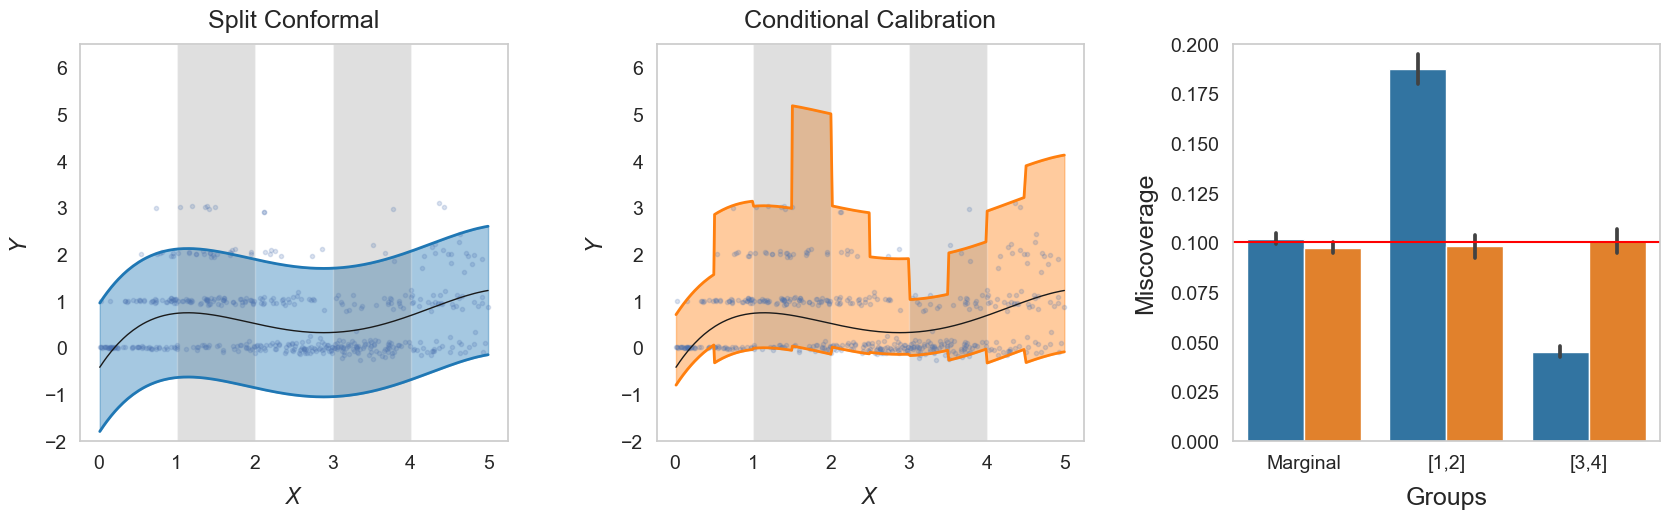

In [8]:
q = np.quantile(np.abs(reg.predict(poly.fit_transform(x_calib)) - y_calib),
                np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)

cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(17.5, 6)

sort_order = np.argsort(x_test[0:n_test,0])
x_test_s = x_test[sort_order]
y_test_s = y_test[sort_order]
y_test_hat = reg.predict(poly.fit_transform(x_test[sort_order]))
lb = lbs[sort_order]
ub = ubs[sort_order]


ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=1, color='k')
ax1.plot(x_test_s, y_test_hat + q, color=cp[0], lw=2)
ax1.plot(x_test_s, y_test_hat - q, color=cp[0], lw=2)
ax1.fill_between(x_test_s.flatten(), y_test_hat - q, y_test_hat + q, 
                 color=cp[0], alpha=0.4, label='split prediction interval')
ax1.set_ylim(-2,6.5)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Split Conformal", fontsize=18, pad=12)

if experiment == 'groups':
    ax1.axvspan(1, 2, facecolor='grey', alpha=0.25)
    ax1.axvspan(3, 4, facecolor='grey', alpha=0.25)
else:
    for loc in eval_locs:
        ax1.plot(x_test_s, norm.pdf(x_test_s, loc=loc, scale=eval_scale), color='grey', ls='--', lw=3)

ax2 = fig.add_subplot(1, 3, 2, sharex = ax1, sharey = ax1)
ax2.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax2.plot(x_test_s, y_test_hat, color='k', lw=1)
ax2.plot(x_test_s, ub, color=cp[1], lw=2)
ax2.plot(x_test_s, lb, color=cp[1], lw=2)
ax2.fill_between(x_test_s.flatten(), lb, 
                 ub, 
                 color=cp[1], alpha=0.4, label='conditional calibration')
ax2.tick_params(axis='both', which='major', direction='out', labelsize=14)
ax2.set_xlabel("$X$", fontsize=16, labelpad=10)
ax2.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax2.set_title("Conditional Calibration", fontsize=18, pad=12)

if experiment == 'groups':
    ax2.axvspan(1, 2, facecolor='grey', alpha=0.25)
    ax2.axvspan(3, 4, facecolor='grey', alpha=0.25)
else:
    for loc in eval_locs:
        ax2.plot(x_test_s, norm.pdf(x_test_s, loc=loc, scale=eval_scale), color='grey', ls='--', lw=3)
    
ax3 = fig.add_subplot(1, 3, 3)
f = sns.barplot(
    coverageData, 
    x='Range', 
    y='Miscoverage',
    hue='Method',
    palette=cp,
    ax = ax3
)
f.axhline(0.1, color='red')
f.legend_.remove()
ax3.set_ylabel("Miscoverage", fontsize=18, labelpad=10)
if experiment == 'groups':
    ax3.set_xlabel("Groups", fontsize=18, labelpad=10)
else:
    ax3.set_xlabel("Shifts", fontsize=18, labelpad=10)
ax3.set_ylim(0.,0.2)
ax3.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout(pad=3)

# plt.savefig(f'figures/cqrDataComparison_{experiment}.pdf')

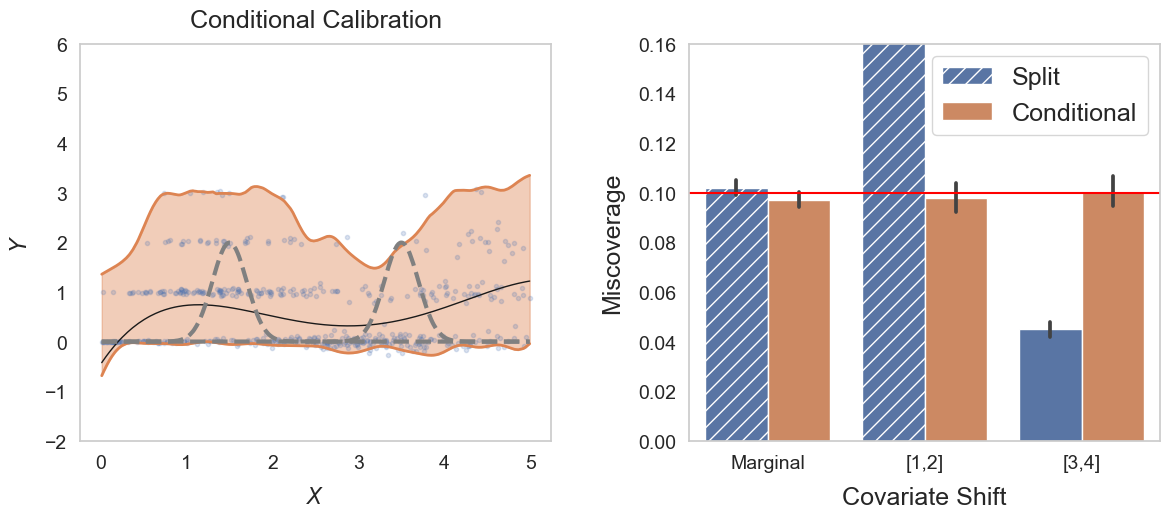

In [121]:
#fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(12.5, 6)

sort_order = np.argsort(x_test[0:n_test,0])
x_test_s = x_test[sort_order]
y_test_s = y_test[sort_order]
y_test_hat = reg.predict(poly.fit_transform(x_test[sort_order]))
lb_ag = lbs[sort_order]
ub_ag = ubs[sort_order]

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=1, color='k')
ax1.plot(x_test_s, ub_ag, color=cp[1], lw=2)
ax1.plot(x_test_s, lb_ag, color=cp[1], lw=2)
ax1.fill_between(x_test_s.flatten(), lb_ag, ub_ag, 
                 color=cp[1], alpha=0.4, label='conditional calibration')
ax1.set_ylim(-2,6)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Conditional Calibration", fontsize=18, pad=12)

for loc in eval_locs:
    ax1.plot(x_test_s, norm.pdf(x_test_s, loc=loc, scale=eval_scale), color='grey', ls='--', lw=3)

ax2 = fig.add_subplot(1, 2, 2)

f = sns.barplot(
    coverageData, 
    x='Range', 
    y='Miscoverage',
    hue='Method',
    palette=cp,
    ax = ax2
)
orange = f.patches[2].get_facecolor()
f.patches[0].set_hatch('//')
f.patches[0].set_facecolor(orange)
f.patches[1].set_hatch('//')
f.patches[1].set_facecolor(orange)

plt.draw()
f.axhline(0.1, color='red')
f.legend_.remove()
# plt.legend(fontsize=18)
ax2.set_ylabel("Miscoverage", fontsize=18, labelpad=10)
ax2.set_xlabel("Covariate Shift", fontsize=18, labelpad=10)
ax2.set_ylim(0.,0.16)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.legend(fontsize=18)
plt.tight_layout(pad=3)

# plt.savefig(f'figures/cqrDataComparison_{experiment}.pdf')